# Transform raw data to same coordinate frame

- Problem: smartphone can be oriented in various ways in the user's pocket and user can be walking in different directions, turn, etc.
- Try to reorient acceleration to be in the same coordinate space with user facing forward
- From gravity vector, we know down-direction. Then project acceleration onto the plane perpendicular to gravity, and use PCA to find direction of the walk (largest component of acceleration). The acceleration is maximal in the forward direction (assumption)
- This is extra, and hasn't been incorporated into the downstream model input yet...

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
from gaitkeeper import load
from gaitkeeper import preprocess

In [3]:
df = load.get_reference_data(3,1)
df.head()

,accelerometer_x_data,accelerometer_y_data,accelerometer_z_data,gravity_x_data,gravity_y_data,gravity_z_data,gyroscope_x_data,gyroscope_y_data,gyroscope_z_data,linearaccelerometer_x_data,linearaccelerometer_y_data,linearaccelerometer_z_data,rotvec_x_data,rotvec_y_data,rotvec_z_data
timestamp,,,,,,,,,,,,,,,
00:00:00,-2.108543,-8.566605,0.407181,0.046391,-9.739213,1.145575,-1.475784,0.029007,-0.486577,-0.676213,1.722519,-1.467486,-0.663411,0.038370,-0.046700
00:00:00.016666,-1.803841,-8.498444,-0.637421,0.103924,-9.759982,0.949072,-1.709951,-0.159144,-0.556208,-2.843566,0.915535,-0.228552,-0.671020,0.036619,-0.048223
00:00:00.033333,-0.590782,-8.829330,0.689728,0.175198,-9.783282,0.649032,-1.687038,0.771389,-0.342209,-1.357904,1.145248,-0.847709,-0.682340,0.036237,-0.051759
00:00:00.050000,-0.200684,-9.505050,2.484306,0.216924,-9.798564,0.329357,-1.643972,1.802124,-0.213720,-0.522788,0.346807,1.971531,-0.693711,0.044312,-0.061680
00:00:00.066666,-0.519356,-9.894890,2.337372,0.238562,-9.802806,0.128560,-1.555608,1.829402,-0.205994,-0.410317,-0.007471,2.424177,-0.700408,0.053550,-0.071495


In [4]:
chunkgen = preprocess.generate_walk_chunks(df)

In [5]:
def plot_log(df, logtype):
    f, ax = plt.subplots()
    df = df[[f"{logtype}_x_data",f"{logtype}_y_data",f"{logtype}_z_data"]].copy()
    df["mag"] = np.linalg.norm(df.values, axis=1)
    df.plot.line(y=[f"{logtype}_x_data",f"{logtype}_y_data",f"{logtype}_z_data", "mag"], ax=ax)
    ax.set_ylabel(f"{logtype}")
    ax.set_xlabel("Time")
    ax.legend(["x", "y", "z", "mag"], loc="best")
    sns.despine()

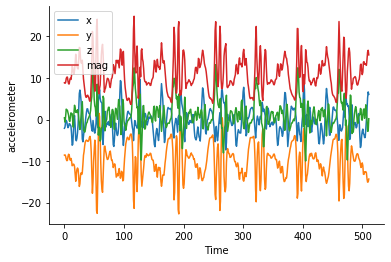

In [6]:
plot_log(next(chunkgen), "accelerometer")

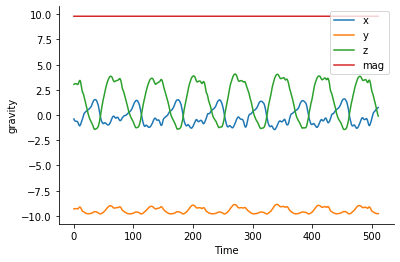

In [7]:
plot_log(next(chunkgen), "gravity")

In [8]:
# To get the direction of gravity, average over the entire timeseries
# Need to rescale final magnitude to gravity
g = df[["gravity_x_data", "gravity_y_data", "gravity_z_data"]].mean()
g_mag = np.linalg.norm(df[["gravity_x_data", "gravity_y_data", "gravity_z_data"]], axis=1).mean()
g_u = g.values / np.linalg.norm(g) #* (g_mag/np.linalg.norm(g))

In [9]:
g_u # normal unit vector

array([ 0.03380049, -0.98370116,  0.17660567])

In [10]:
chunk = next(chunkgen)

In [11]:
# Project linear acceleration onto the gravity plane (g = normal vector, here)
acc = chunk[["linearaccelerometer_x_data", "linearaccelerometer_y_data", "linearaccelerometer_z_data"]].values

In [12]:
# Test to check that dot product is what we expect
print(np.dot(acc, g_u)[0])
print(acc[0,0] * g_u[0] + acc[0,1] * g_u[1] + acc[0,2] * g_u[2])
assert np.isclose(np.dot(acc, g_u)[0], (acc[0,0] * g_u[0] + acc[0,1] * g_u[1] + acc[0,2] * g_u[2]))

4.396677483588121
4.396677483588121


In [13]:
# acc . g_u * g_u gives the acc vector projected onto gravity
# we subtract this component in the direction of gravity from acc to get the acceleration orthogonal to gravity only
acc_user = acc - np.dot(acc, g_u).reshape(-1, 1) * g_u

In [15]:
pca = PCA(2)
results = pca.fit_transform(acc_user)

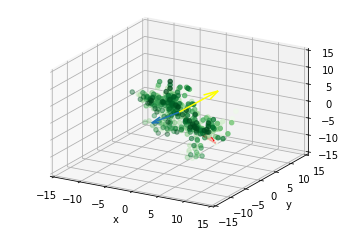

In [16]:
# %matplotlib widget
# Plot vectors on plane to double-check if projection was correct
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d', proj_type='ortho')
ax.scatter3D(acc_user[:,0], acc_user[:,1], acc_user[:,2], c=list(range(len(acc_user))), cmap='Greens')
ax.quiver(0, 0, 0, g_u[0]*9.8, g_u[1]*9.8, g_u[2]*9.8)
# Plot PCA components
ax.quiver(0, 0, 0, pca.components_[0,0]*10, pca.components_[0,1]*10, pca.components_[0,2]*10, color="red")
ax.quiver(0, 0, 0, pca.components_[1,0]*10, pca.components_[1,1]*10, pca.components_[1,2]*10, color="yellow")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
ax.set_zlim(-15, 15)
plt.show()

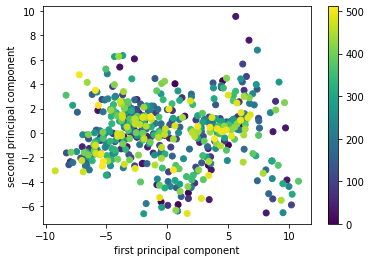

In [17]:
f, ax = plt.subplots()
c = ax.scatter(results[:3000,0], results[:3000,1], c=list(range(len(acc_user)))[:3000])
ax.set_xlabel("first principal component")
ax.set_ylabel("second principal component")
plt.colorbar(c)

In [ ]:
np.dot(pca.components_[0],pca.components_[1])  # just verifying PCA components are orthogonal